Alex Malz, David Mykytyn

In [1]:
from collections import namedtuple
import numpy as np
import scipy.stats as sps
import scipy.optimize as spo
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
LC = namedtuple('LC', ('x', 'y'))

 may need to preprocess to keep it reasonable, constraints on delta/stretch

# Simulate some mock data

In [3]:
def make_gauss(loc, scale, amp=1., const=0.):
    func = sps.norm(loc, scale)
    out = lambda x: amp * func.pdf(x) + const
    return out

def make_sine(period, phase=0., amp=1., const=0.):
    func = lambda x: amp * (np.sin(period * x + phase)) + const
    return func

In [4]:
def make_cadence(x, scatter):
    assert(np.all((x[1:]-x[:-1]) > scatter))
    jitter = (np.random.uniform(np.shape(x)) - 0.5) * scatter * 2.
    perturbed = x + jitter
    return perturbed

def noisify_obs(y, scatter):
    errs = scatter * np.ones_like(y)
    new_y = y + sps.norm(0., scatter).rvs(np.shape(y))
    return(new_y, errs)

In [5]:
def_cadence = np.arange(0., 200., 5.)

gmodel = make_gauss(100., 10., 50., 1.)
gtimes = make_cadence(def_cadence, 0.5)
gphot, gerr = noisify_obs(gmodel(gtimes), 0.1)
glc = LC(gtimes, gphot)

smodel = make_sine(20., 0., 5., 5.)
stimes = make_cadence(def_cadence, 0.5)
sphot, serr = noisify_obs(smodel(stimes), 0.3)
slc = LC(stimes, sphot)

<ErrorbarContainer object of 3 artists>

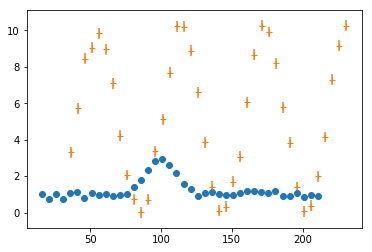

In [6]:
plt.errorbar(glc.x, glc.y, yerr=gerr, linestyle='None', marker='o')
plt.errorbar(slc.x, slc.y, yerr=serr, linestyle='None', marker='+')

## Permitted transformations

* shiftx
* stretchx
* shifty
* stretchy
* (cross-talk between bands)


In [7]:
def transform(lc, deltax, deltay, stretchx, stretchy):
    new_x = (stretchx * lc.x) + deltax
    new_y = (stretchy * lc.y) + deltay
    return LC(new_x, new_y)

def merge(lca, lcb):
    new_x = np.concatenate((lca.x, lcb.x))
    new_y = np.concatenate((lca.y, lcb.y))
    order = np.argsort(new_x)
    ord_x = new_x[order]
    ord_y = new_y[order]
    return LC(ord_x, ord_y)

# Reduce to summary statistics (consistency metric)

Contenders:

* periodogram -- identify periodicity and stochastic noise levels
* flux per time bins -- trends keeping bin size constant but changing bin ends
* abs/percent change in color and total flux/magnitude

find MAP/MLE of p(A = B | lc_A, lc_B)
optimize over shift/stretch params

merge (x_A, x_B) and (y_A, y_B)

In [8]:
def connect_the_dots(lc):
    x_difs = lc.x[1:] - lc.x[:-1]
    y_difs = lc.y[1:] - lc.y[:-1]
    sol = np.sqrt(x_difs ** 2 + y_difs **2)
    return np.sum(sol)

(195.25234692973518, 195.25234692973518, 268.76750638352564)


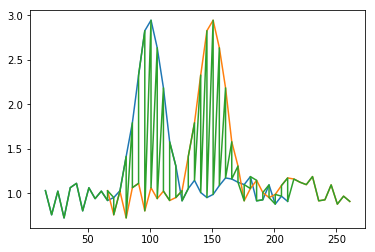

In [48]:
gtimes2 = gtimes + 50. * np.ones_like(gtimes)#ake_cadence(def_cadence, 0.5)
gphot2, gerr2 = gphot, gerr#noisify_obs(gmodel(gtimes2), 0.1)
glc2 = LC(gtimes2, gphot2)
# glc2 = transform(glc, 5., 0., 1., 1.)
plt.plot(glc.x, glc.y)
plt.plot(glc2.x, glc2.y)
plt.plot(merge(glc, glc2).x, merge(glc, glc2).y)
print((connect_the_dots(glc), connect_the_dots(glc2), connect_the_dots(merge(glc, glc2))))

In [49]:
print((connect_the_dots(glc), connect_the_dots(glc2), connect_the_dots(merge(glc, transform(glc2, -0.5, 0., 1., 1.)))))

(195.25234692973518, 195.25234692973518, 261.23413997099476)


In [50]:
def find_max_prob(lca, lcb):
    
    origa = connect_the_dots(lca)
    xdifmax = np.max((lca.x[-1]-lca.x[0], lcb.x[-1]-lcb.x[0]))
    xdifmin = np.min((np.min(lca.x[1:]-lca.x[:-1]), np.min(lcb.x[-1]-lcb.x[0])))
    ydifmax = np.max((np.max(lca.y)-np.min(lca.y), np.max(lcb.y)-np.min(lcb.y)))
    ydifmin = np.min((np.min(lca.y[1:]-lca.y[:-1]), np.min(lcb.y[-1]-lcb.y[0])))

    def dxlim_hi(params):
        return xdifmax - params[0]
    def dxlim_lo(params):
        return params[0] - xdifmin
    def dylim_hi(params):
        return ydifmax - params[1]
    def dylim_lo(params):
        return params[1] - ydifmin
    def sxlim_hi(params):
        return xdifmax - params[2] * xdifmin
    def sxlim_lo(params):
        return params[2] * xdifmax - xdifmin
    def sylim_hi(params):
        return ydifmax - params[3] * ydifmin
    def sylim_lo(params):
        return params[3] * ydifmax - ydifmin
    def slim(params):
        return params[2:]

    constraints = [dxlim_hi, dxlim_lo, dylim_hi, dylim_lo, sxlim_hi, sxlim_lo, sylim_hi, sylim_lo, slim]
    
    debug = []
    def _helper(params):
        (deltax, deltay, stretchx, stretchy) = params
        lc = transform(lcb, deltax, deltay, stretchx, stretchy)
        new_len = connect_the_dots(lc)
        lc_both = merge(lca, lc) 
        length = connect_the_dots(lc_both)# / stretchy * stretchx
        to_min = length - origa
        debug.append(to_min)
        return(to_min)
    
    ivals = (0., 0., 1., 1.)
    res = spo.fmin_cobyla(_helper, ivals, constraints)
    return(res, debug)



[ 5.09838727 -0.04981349  0.63408049  1.0637333 ]


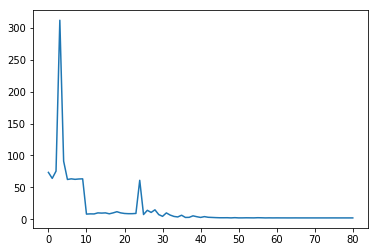

In [51]:
ans, debug = find_max_prob(glc, glc2)
print(ans)
plt.plot(debug)

124.09456356914701


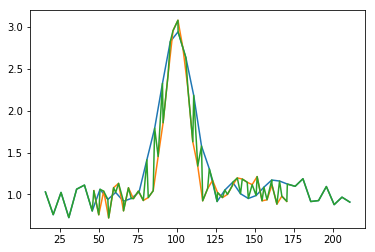

In [52]:
(dx, dy, sx, sy) = ans
fin = transform(glc2, dx, dy, sx, sy)
print(connect_the_dots(fin))
plt.plot(glc.x, glc.y)
plt.plot(fin.x, fin.y)
plt.plot(merge(glc, fin).x, merge(glc, fin).y)

In [42]:
help(spo.minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where x is an 1-D array with shape (n,) and `args`
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see here) <op

# Cluster in the space of summary statistics

kdtree (and more)

# Other ideas

pairwise combinations/comparisons?